# 회귀 실습 - 자전거 대여 수요 예측

출처: http://www.kaggle.com/c/bike-sharing-demand/overview

## 데이터 클렌징 및 가공과 데이터 시각화

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
bike_df = pd.read_csv('/Users/pakeunseo/Desktop/2024-2/multicampus/py_ml_env/data/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
# 문자열을 datetime으로 변경 
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime에서 년,월,일,시간 추출 
bike_df['year']= bike_df.datetime.apply(lambda x : x.year)
bike_df['month']= bike_df.datetime.apply(lambda x : x.month)
bike_df['day']= bike_df.datetime.apply(lambda x : x.day)
bike_df['hour']= bike_df.datetime.apply(lambda x : x.hour)

In [9]:
# 불필요한 열 제거 
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

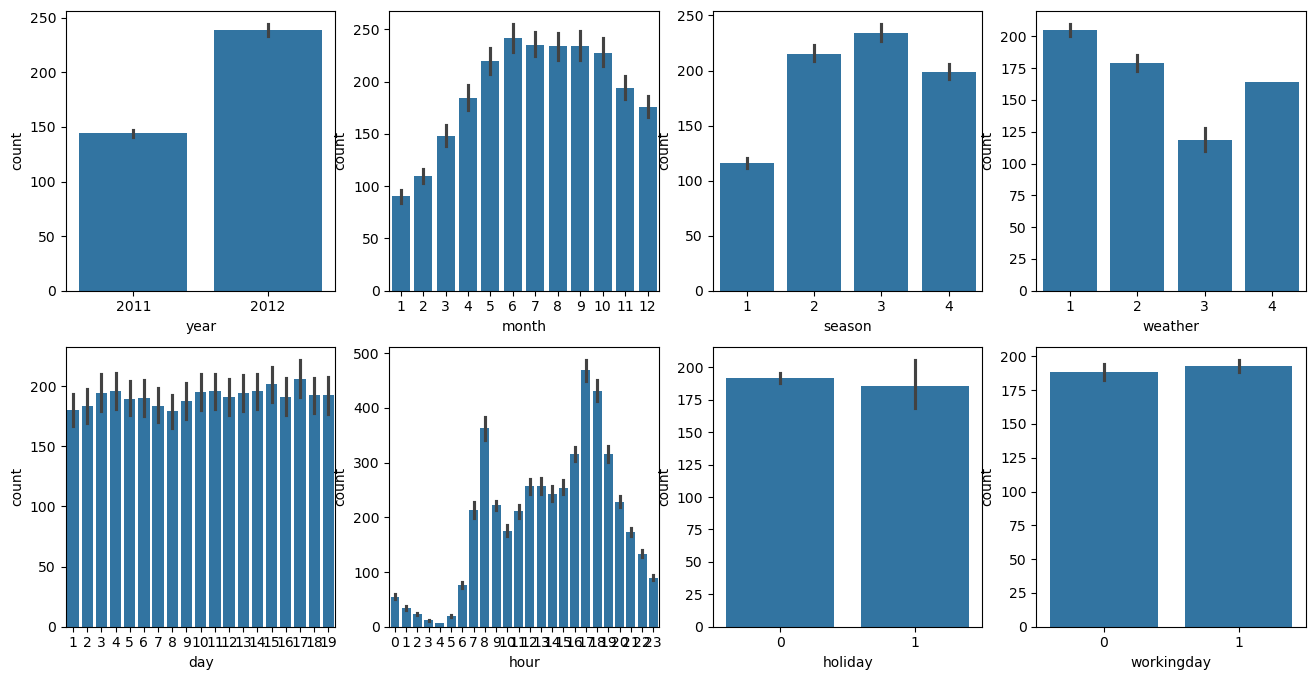

In [12]:
fig,axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
cat_features= ['year','month','season','weather','day','hour','holiday','workingday']

for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    sns.barplot(x=feature, y='count', data= bike_df, ax=axs[row][col])

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE계산
def rmsle(y,pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

#사이킷런의 mean_square_error()을 이용해 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    #MAE는 사이킷런의 mean_absolute_error로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f} RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val,rmse_val,mae_val))

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가

*회귀 모델 적용 전 체크 사항
1. 결과값이 정규 분포로 되어 있는지 확인
2. 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처 인코딩

In [19]:
# 사이킷런 LinearRegression 객체를 이용해 회귀 예측 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=11)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred= lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.176 RMSE: 143.308, MAE: 107.367


In [20]:
# 실제값과 예측값의 차 확인 
def get_top_error_date(y_test, pred, n_tops =5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predict_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predict_count'] )
    
    #예측값과 실제 값의 차가 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_date(y_test, pred, n_tops=5)

      real_count  predict_count   diff
537          835          213.0  622.0
2860         809          194.0  615.0
1259         784          179.0  605.0
2098         731          142.0  589.0
887          968          406.0  562.0


예측 오류가 꽤 크다. 회귀에서 이렇게 큰 예측 오류가 발생한 경우 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인해야 한다. 

<AxesSubplot:>

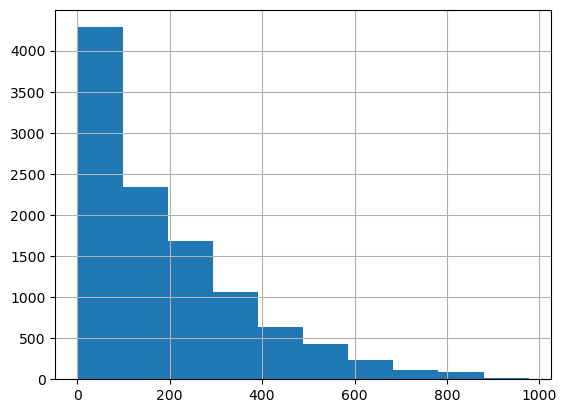

In [22]:
y_target.hist()

<AxesSubplot:>

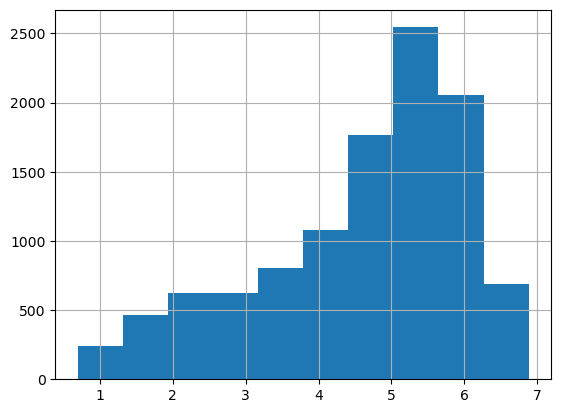

In [25]:
# log1p()를 활용하여 왜곡 완화 
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [26]:
#target column인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=11)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred= lr_reg.predict(X_test)

#테스트 데이터 셋의 Target값은 로그 변환되었으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

#예측값 역시 로그 변환된 타깃 기반으로 학습되어 예측되었으므로 다시 expm1로 스케일 변환 
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.027 RMSE: 161.615, MAE: 108.537


RMSE 오류는 줄어들었으나 RMSE 값은 늘어났다. 따라서 개별 피러들의 인코딩을 적용해보겠다.

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 피처의 관계성 - 다중공선성, 상관관계 파악
X_check = bike_df[['temp', 'atemp', 'holiday', 'workingday', 'season']]
X_with_const = add_constant(X_check)
x_vif_df = pd.DataFrame()
x_vif_df['Feature'] = X_with_const.columns
x_vif_df['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# 결과 출력
print(x_vif_df)

      Feature        VIF
0       const  14.366430
1        temp  33.568616
2       atemp  33.673455
3     holiday   1.069674
4  workingday   1.069512
5      season   1.076713


<AxesSubplot:ylabel='None'>

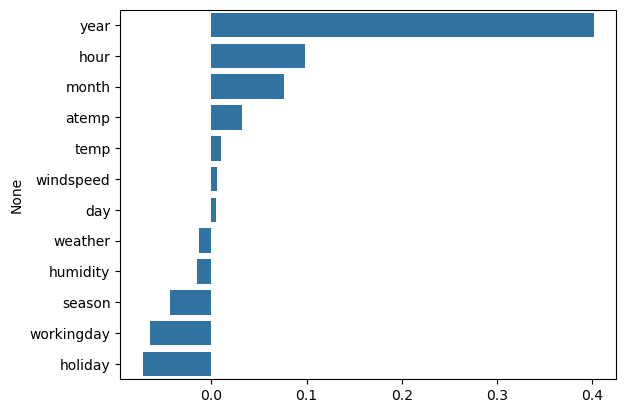

In [27]:
# 각 피처의 회귀 계숫값 시각화
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x= coef_sort.values, y = coef_sort.index)

year, hour, month, season, holiday, workingday 피처들의 회귀 계수 영향도가 상대적으로 높다. \
year, month 이러한 열들은 개별 숫자값의 크기가 무의미 하다. \
따라서 Year의 경우 단순히 연도를 뜻하는 거지 2012 값이 2011보다 큰 값으로 인식되어서는 안된다. \
즉 year, hour, month 등은 숫자 값으로 표현되었지만 이들은 category형 피처다.

사이킷런은 카테고리만을 위한 데이터 타입이 없어 모두 숫자로 변환해야 한다. \
허나 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다.\
따라서 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 한다.

In [29]:
# 카테고리형 피처 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns = ['year','hour','month','season','holiday','workingday','day','weather'])

In [53]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: 0.590 RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590 RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635 RMSE: 113.219, MAE: 72.803


<AxesSubplot:ylabel='None'>

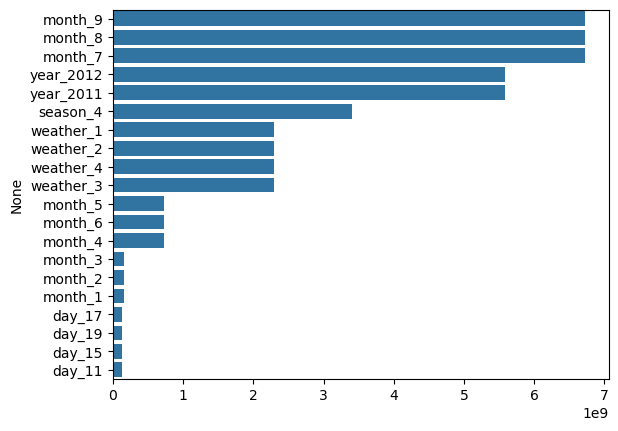

In [54]:
# 각 피처의 회귀 계숫값 시각화
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending = False)[:20]
sns.barplot(x= coef_sort.values, y = coef_sort.index)

## 회귀 트리

In [55]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)


### RandomForestRegressor ###
RMSLE: 0.354 RMSE: 50.458, MAE: 31.247
### GradientBoostingRegressor ###
RMSLE: 0.330 RMSE: 53.333, MAE: 32.740
### XGBRegressor ###
RMSLE: 0.342 RMSE: 51.726, MAE: 31.256
### LGBMRegressor ###
RMSLE: 0.319 RMSE: 47.215, MAE: 29.029
